In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

akshatabhisheklal_with_mask_path = kagglehub.dataset_download('akshatabhisheklal/with-mask')
akshatabhisheklal_without_mask_path = kagglehub.dataset_download('akshatabhisheklal/without-mask')

print('Data source import complete.')


100%|██████████| 125M/125M [00:01<00:00, 78.3MB/s]

Extracting files...


100%|██████████| 33.5M/33.5M [00:00<00:00, 49.5MB/s]

Extracting files...


Data source import complete.


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.models import Model



from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm

In [6]:
FEATURES_DIR = "/content/features"  # Directory to save features

if not os.path.exists(FEATURES_DIR):
    os.makedirs(FEATURES_DIR)

# Load dataset and extract features for each method
def load_data(feature_extractor, use_sift=False):
    feature_name = feature_extractor.__name__
    feature_file = os.path.join(FEATURES_DIR, f"{feature_name}_features.pkl")

    # If saved features exist, load them
    if os.path.exists(feature_file):
        print(f"Loading saved features for {feature_name}...")
        with open(feature_file, "rb") as f:
            X, y = pickle.load(f)
        return np.array(X), np.array(y)

    X, y = [], []
    sift = cv2.SIFT_create() if use_sift else None
    all_descriptors = []

    for label, path in enumerate([MASKED_PATH, UNMASKED_PATH]):
        for img_name in tqdm(os.listdir(path), desc=f"Extracting {feature_name}"):
            img_path = os.path.join(path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.resize(image, (128, 128))

            if use_sift:
                descriptors = extract_sift_features(image, sift)
                if descriptors is not None:
                    all_descriptors.append(descriptors)
            else:
                features = feature_extractor(image)
                X.append(features)
                y.append(label)

    if use_sift:
        all_descriptors = np.vstack(all_descriptors)
        kmeans = KMeans(n_clusters=128, random_state=42, n_init=10)
        kmeans.fit(all_descriptors)

        for label, path in enumerate([MASKED_PATH, UNMASKED_PATH]):
            for img_name in tqdm(os.listdir(path), desc="Extracting BoW for SIFT"):
                img_path = os.path.join(path, img_name)
                image = cv2.imread(img_path)
                if image is None:
                    continue
                image = cv2.resize(image, (128, 128))
                features = extract_sift_features(image, sift, kmeans)
                X.append(features)
                y.append(label)

    # Save extracted features
    with open(feature_file, "wb") as f:
        pickle.dump((X, y), f)
    print(f"Saved features for {feature_name} to {feature_file}")
    # print(np.array(X).shape, np.array(y).shape)
    return np.array(X), np.array(y)

In [7]:
# Dataset paths (update these based on your dataset)
MASKED_PATH = akshatabhisheklal_with_mask_path
UNMASKED_PATH = akshatabhisheklal_without_mask_path

# Function to extract individual features
def extract_hog(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')

def extract_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 8, 1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)
    return lbp_hist  # LBP Histogram

def extract_color_hist(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_hue = cv2.calcHist([hsv_image], [0], None, [16], [0, 256]).flatten()
    return hist_hue / hist_hue.sum()  # Normalize

def extract_gabor(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gabor_kernel = gabor(gray, frequency=0.2)[0]
    return np.array([gabor_kernel.mean(), gabor_kernel.var()])

def extract_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return np.histogram(edges.ravel(), bins=16, range=(0, 256), density=True)[0]

def extract_sift_features(image, sift, kmeans=None):
    """ Extracts SIFT keypoints and returns BoW representation if kmeans is provided """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    if des is None:
        return np.zeros((128,))  # Return zero vector if no keypoints are detected
    if kmeans is not None:
        labels = kmeans.predict(des)
        bow_vector = np.histogram(labels, bins=np.arange(0, kmeans.n_clusters+1), density=True)[0]
        return bow_vector
    return des  # Return descriptors for clustering phase



# Train and evaluate SVM for a given feature
def train_and_evaluate(feature_extractor, use_sift=False):
    print(f"\nTraining SVM with {feature_extractor.__name__}...")
    X, y = load_data(feature_extractor, use_sift=use_sift)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train SVM
    svm_model = SVC(kernel="linear")
    svm_model.fit(X_train, y_train)

    # Predict
    y_pred = svm_model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"{feature_extractor.__name__} Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("Confusion Matrix:\n", cm)

# Run classification with different features
train_and_evaluate(extract_hog)         # HOG
train_and_evaluate(extract_lbp)         # LBP
train_and_evaluate(extract_color_hist)  # Color Histogram
train_and_evaluate(extract_gabor)       # Gabor
train_and_evaluate(extract_edges)       # Canny Edge
train_and_evaluate(extract_sift_features, use_sift=True)  # SIFT


Training SVM with extract_hog...


Extracting extract_hog: 100%|██████████| 1930/1930 [00:14<00:00, 133.02it/s]


Saved features for extract_hog to /content/features/extract_hog_features.pkl
extract_hog Accuracy: 89.01%
Precision: 0.88
Recall: 0.87
Confusion Matrix:
 [[410  43]
 [ 47 319]]

Training SVM with extract_lbp...


Extracting extract_lbp: 100%|██████████| 1930/1930 [00:06<00:00, 286.00it/s]


Saved features for extract_lbp to /content/features/extract_lbp_features.pkl
extract_lbp Accuracy: 71.67%
Precision: 0.70
Recall: 0.64
Confusion Matrix:
 [[351 102]
 [130 236]]

Training SVM with extract_color_hist...


Extracting extract_color_hist: 100%|██████████| 1930/1930 [00:01<00:00, 1490.31it/s]


Saved features for extract_color_hist to /content/features/extract_color_hist_features.pkl
extract_color_hist Accuracy: 74.11%
Precision: 0.67
Recall: 0.85
Confusion Matrix:
 [[297 156]
 [ 56 310]]

Training SVM with extract_gabor...


Extracting extract_gabor: 100%|██████████| 1930/1930 [00:43<00:00, 44.03it/s]


Saved features for extract_gabor to /content/features/extract_gabor_features.pkl
extract_gabor Accuracy: 61.29%
Precision: 0.58
Recall: 0.47
Confusion Matrix:
 [[329 124]
 [193 173]]

Training SVM with extract_edges...


Extracting extract_edges: 100%|██████████| 1930/1930 [00:03<00:00, 600.63it/s]


Saved features for extract_edges to /content/features/extract_edges_features.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


extract_edges Accuracy: 55.31%
Precision: 0.00
Recall: 0.00
Confusion Matrix:
 [[453   0]
 [366   0]]

Training SVM with extract_sift_features...


Extracting BoW for SIFT: 100%|██████████| 1930/1930 [00:18<00:00, 105.19it/s]


Saved features for extract_sift_features to /content/features/extract_sift_features_features.pkl
extract_sift_features Accuracy: 75.58%
Precision: 0.77
Recall: 0.65
Confusion Matrix:
 [[381  72]
 [128 238]]


In [12]:
# combine the features into a vector data

COMBINED_FEATURES_FILE = os.path.join("/content/combined_features.pkl")

def load_saved_features():
    feature_files = [
        "extract_hog_features.pkl",
        "extract_lbp_features.pkl",
        "extract_color_hist_features.pkl",
        "extract_gabor_features.pkl",
        "extract_edges_features.pkl",
        "extract_sift_features.pkl"
    ]

    loaded_features = []
    y_labels = None

    for file in feature_files:
        feature_path = os.path.join(FEATURES_DIR, file)
        if os.path.exists(feature_path):
            print(f"Loading {file}...")
            with open(feature_path, "rb") as f:
                X, y = pickle.load(f)
                loaded_features.append(X)

                # Ensure labels are the same across all features
                if y_labels is None:
                    y_labels = y
                elif not np.array_equal(y_labels, y):
                    raise ValueError(f"Mismatch in labels for {file}")

    # Stack all feature vectors horizontally
    X_combined = np.hstack(loaded_features)

    # Save the final feature vector
    with open(COMBINED_FEATURES_FILE, "wb") as f:
        pickle.dump((X_combined, y_labels), f)
    print(f"Saved combined features to {COMBINED_FEATURES_FILE}")

    return X_combined, y_labels

Loading extract_hog_features.pkl...
Loading extract_lbp_features.pkl...
Loading extract_color_hist_features.pkl...
Loading extract_gabor_features.pkl...
Loading extract_edges_features.pkl...
Saved combined features to /content/combined_features.pkl
(4095, 8144)
New shape after PCA: (4095, 50)

Training Random Forest...
Random Forest Accuracy: 91.09%
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       453
           1       0.93      0.86      0.90       366

    accuracy                           0.91       819
   macro avg       0.91      0.91      0.91       819
weighted avg       0.91      0.91      0.91       819



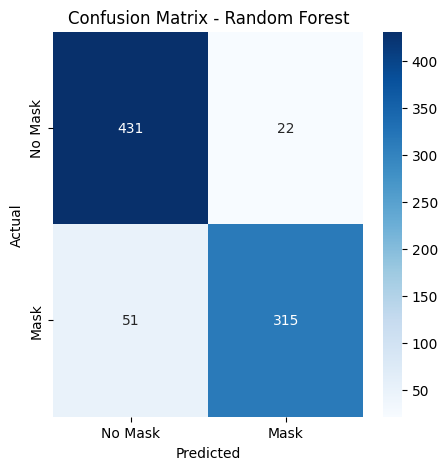


Training Naive Bayes...
Naive Bayes Accuracy: 83.39%
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       453
           1       0.81      0.81      0.81       366

    accuracy                           0.83       819
   macro avg       0.83      0.83      0.83       819
weighted avg       0.83      0.83      0.83       819



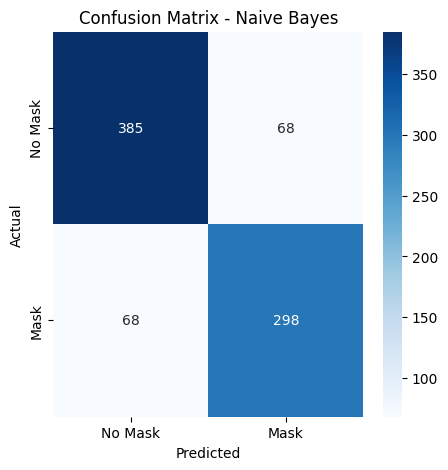

In [13]:
def train_and_evaluate_models():
    # Load the combined feature vectors
    X, y = load_saved_features()
    print(X.shape)
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=50)
    reduced_features = pca.fit_transform(X)

    print("New shape after PCA:", reduced_features.shape)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(reduced_features, y, test_size=0.2, random_state=42)

    # Define ML models to train
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Naive Bayes": GaussianNB()
    }

    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate model
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f"{model_name} Accuracy: {acc * 100:.2f}%")
        print(f"Classification Report:\n{report}")

        # Plot confusion matrix
        plt.figure(figsize=(5, 5))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Mask", "Mask"], yticklabels=["No Mask", "Mask"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {model_name}")
        plt.show()

# Run the training and evaluation
train_and_evaluate_models()


**Binary Classification Using CNN**

In [14]:
# Path to the folder containing images
MASKED_PATH = akshatabhisheklal_with_mask_path
UNMASKED_PATH = akshatabhisheklal_without_mask_path
image_folder = akshatabhisheklal_without_mask_path

widths, heights = [], []

for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)  # Read image
    if img is not None:
        h, w = img.shape[:2]  # Get height and width
        widths.append(w)
        heights.append(h)

# Compute statistics
avg_width, avg_height = np.mean(widths), np.mean(heights)
min_width, min_height = np.min(widths), np.min(heights)
max_width, max_height = np.max(widths), np.max(heights)

# Display results
print(f"Average Image Size: {avg_width:.2f} x {avg_height:.2f}")
print(f"Min Image Size: {min_width} x {min_height}")
print(f"Max Image Size: {max_width} x {max_height}")


Average Image Size: 212.00 x 226.15
Min Image Size: 95 x 88
Max Image Size: 960 x 960


In [15]:
# Constants
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 100

# Load dataset and preprocess
def load_images():
    X, y = [], []
    for label, path in enumerate([MASKED_PATH, UNMASKED_PATH]):
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0  # Normalize
            X.append(image)
            y.append(label)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    return train_test_split(X, y, test_size=0.2, random_state=42)

# Load dataset
X_train, X_test, y_train, y_test = load_images()

In [16]:
def create_cnn(activation='relu', optimizer='adam'):
    model = Sequential([
        Conv2D(32, (3,3), activation=activation, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation=activation),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation=activation),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation=activation),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
# Hyperparameter variations
variations = [
    ('relu', 'adam'),
    ('relu', 'sgd'),
    ('tanh', 'adam'),
    ('tanh', 'sgd')
]

for activation, optimizer in variations:
    print(f"\nTraining CNN with activation={activation}, optimizer={optimizer}")
    model = create_cnn(activation, optimizer)

    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), verbose=1)

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy ({activation}, {optimizer}): {test_acc * 100:.2f}%")


Training CNN with activation=relu, optimizer=adam


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.7630 - loss: 0.5060 - val_accuracy: 0.9023 - val_loss: 0.2894
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9131 - loss: 0.2498 - val_accuracy: 0.9206 - val_loss: 0.2082
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9423 - loss: 0.1676 - val_accuracy: 0.9267 - val_loss: 0.1889
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9420 - loss: 0.1552 - val_accuracy: 0.9512 - val_loss: 0.1359
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9601 - loss: 0.1103 - val_accuracy: 0.9585 - val_loss: 0.1160
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9588 - loss: 0.1089 - val_accuracy: 0.9475 - val_loss: 0.1407
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9685 - loss: 0.0889 - val_accuracy: 0.9609 - val_loss: 0.1295
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9707 - loss: 0.0730 -

**RESULT COMPARISION**

In [18]:
def create_cnn_v2(activation='relu', optimizer='adam'):
    model = Sequential([
        Conv2D(32, (3,3), activation=activation, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation=activation),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation=activation),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(256, (3,3), activation=activation),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(256, activation=activation),
        Dropout(0.5),
        Dense(128, activation=activation),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [19]:
EPOCHS = 50
variations = [
    ('relu', 'adam'),
    ('relu', 'sgd'),
    ('tanh', 'adam'),
    ('tanh', 'sgd')
]

for activation, optimizer in variations:
    print(f"\nTraining CNN with activation={activation}, optimizer={optimizer}")
    model = create_cnn_v2(activation, optimizer)

    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), verbose=1)

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy ({activation}, {optimizer}): {test_acc * 100:.2f}%")


Training CNN with activation=relu, optimizer=adam
Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.7965 - loss: 1.2483 - val_accuracy: 0.5824 - val_loss: 2.2739
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8872 - loss: 0.6514 - val_accuracy: 0.6044 - val_loss: 1.5334
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8953 - loss: 0.3919 - val_accuracy: 0.7192 - val_loss: 0.9489
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9235 - loss: 0.2830 - val_accuracy: 0.8547 - val_loss: 0.3328
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9370 - loss: 0.1887 - val_accuracy: 0.9219 - val_loss: 0.2079
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9494 - loss: 0.1593 - val_accuracy: 0.9133 - val_loss: 0.1912
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9519 - loss: 0.1376 - val_accuracy: 0.9316 - val_loss: 0.1782
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 2